In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from prophet import Prophet
from datetime import timedelta
import os

# Load the data from CSV
# ['500108082' '500105101' '500119097' '500101181' '500105056']

station = "500105056"
file_path = f"../../data/prediction/processed_data_all_stations_weather_{station}.csv"
os.makedirs(f"./predictionResults/{station}", exist_ok=True)
# Load your DataFrame
df_youbike = pd.read_csv(file_path, parse_dates=["timestamp"])
#ensure it ends on midnight
df_youbike = df_youbike[df_youbike["timestamp"] < df_youbike["timestamp"].max().replace(hour=0, minute=0, second=0, microsecond=0)]
df_youbike.set_index("timestamp", inplace=True)
df_youbike.tail()

,youbike_station_id,available_rent_bikes,available_return_bikes,capacity,demand,temperature
timestamp,,,,,,
2025-03-18 23:10:00,500105056,6,7.0,13.0,0,10.694118
2025-03-18 23:20:00,500105056,6,7.0,13.0,0,10.711765
2025-03-18 23:30:00,500105056,6,7.0,13.0,0,10.617647
2025-03-18 23:40:00,500105056,6,7.0,13.0,0,10.529412
2025-03-18 23:50:00,500105056,6,7.0,13.0,0,10.517647


In [2]:
df_youbike.head()

,youbike_station_id,available_rent_bikes,available_return_bikes,capacity,demand,temperature
timestamp,,,,,,
2025-02-13 00:00:00,500105056,6,7.0,13.0,0,16.344444
2025-02-13 00:10:00,500105056,6,7.0,13.0,0,15.926316
2025-02-13 00:20:00,500105056,6,7.0,13.0,0,15.873684
2025-02-13 00:30:00,500105056,6,7.0,13.0,0,15.842105
2025-02-13 00:40:00,500105056,6,7.0,13.0,0,15.800000


In [3]:
# Model 1: Naïve Forecast (Same values as today)
def naive_forecast(df_youbike):
    return df_youbike.shift(24 * 6).loc[y_test.index]  # Align with y_test

# Model 2: Weekly Averaging Model
def weekly_avg_forecast(df_youbike):
    return ((df_youbike + df_youbike.shift(7 * 24 * 6)) / 2).loc[y_test.index]  # Align with y_test

# Prepare dataset for supervised learning
lag =  24 * 6  # 1-day lag to predict 1-day ahead
df_ml = df_youbike.copy()

# Feature Engineering
# Add rolling averages to smooth out fluctuations
df_ml['rolling_mean_3h'] = df_youbike['available_rent_bikes'].rolling(window=18).mean()
df_ml['rolling_mean_6h'] = df_youbike['available_rent_bikes'].rolling(window=36).mean()
df_ml['rolling_std_3h'] = df_youbike['available_rent_bikes'].rolling(window=18).std()
df_ml['rolling_std_6h'] = df_youbike['available_rent_bikes'].rolling(window=36).std()

# Add time-based features
df_ml['hour'] = df_youbike.index.hour
df_ml['day_of_week'] = df_youbike.index.dayofweek
df_ml['is_weekend'] = (df_ml['day_of_week'] >= 5).astype(int)

# Lagged Differences for Trend Capture
df_ml['diff_1'] = df_youbike['available_rent_bikes'].diff(1)
df_ml['diff_6h'] = df_youbike['available_rent_bikes'].diff(36)
df_ml['diff_12h'] = df_youbike['available_rent_bikes'].diff(72)


lagged_features = {f"lag_{i}": df_youbike["available_rent_bikes"].shift(i) for i in range(1, lag + 1)}
df_ml = pd.concat([df_ml, pd.DataFrame(lagged_features, index=df_youbike.index)], axis=1)

df_ml.dropna(inplace=True)
X = df_ml.drop(columns=["available_return_bikes", "youbike_station_id",
                        "capacity", "demand"])[:-(lag)]
y = df_ml["available_rent_bikes"][lag:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model 3: Linear Regression
from sklearn.linear_model import Ridge
lin_reg = Ridge(alpha=1.0)
# lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = pd.Series(lin_reg.predict(X_test), index=y_test.index)

# Model 4: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = pd.Series(rf.predict(X_test), index=y_test.index)


from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Model 6: ARIMA
# best_arima = auto_arima(y_train, seasonal=False, trace=True, stepwise=True)
arima_model = ARIMA(y_train, order=(1,0,2))
arima_fit = arima_model.fit()
y_pred_arima = pd.Series(arima_fit.forecast(steps=len(y_test)), index=y_test.index)

# Model 7: Prophet
prophet_df = df_youbike.reset_index().rename(columns={"timestamp": "ds", "available_rent_bikes": "y"})
prophet = Prophet()
prophet.fit(prophet_df)
future = prophet.make_future_dataframe(periods=len(y_test), freq="10min")
forecast = prophet.predict(future)
y_pred_prophet = forecast.set_index("ds")["yhat"].loc[y_test.index]  # Align with y_test

# Combine predictions into a DataFrame
results = pd.DataFrame({
    "Naïve": naive_forecast(df_youbike)["available_rent_bikes"],
    "Weekly Avg": weekly_avg_forecast(df_youbike)["available_rent_bikes"],
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "Prophet": y_pred_prophet,
    "ARIMA": y_pred_arima
})

print(results.head())  # Preview results
# results.to_csv(f"predictionResults/forecast_results_{station}.csv")  # Uncomment to save


/media/mojoee/01fc00c5-9a41-40f6-8f0e-d25ee6a8c4be/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
/media/mojoee/01fc00c5-9a41-40f6-8f0e-d25ee6a8c4be/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
/media/mojoee/01fc00c5-9a41-40f6-8f0e-d25ee6a8c4be/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
13:01:47 - cmdstanpy - INFO - Chain [1] start processing
13:01:48 - cmdstanpy - INFO - Chain [1] done processing


                     Naïve  Weekly Avg  Linear Regression  Random Forest  \
timestamp                                                                  
2025-03-12 14:20:00    7.0         5.0           4.208133           3.87   
2025-03-12 14:30:00    6.0         5.0           4.082715           3.29   
2025-03-12 14:40:00    7.0         5.0           3.729658           3.09   
2025-03-12 14:50:00    7.0         5.0           3.511354           3.15   
2025-03-12 15:00:00    7.0         5.0           3.518436           2.82   

                      Prophet     ARIMA  
timestamp                                
2025-03-12 14:20:00  6.267813  5.026803  
2025-03-12 14:30:00  6.252673  5.042886  
2025-03-12 14:40:00  6.234145  5.068937  
2025-03-12 14:50:00  6.211251  5.094030  
2025-03-12 15:00:00  6.183155  5.118200  


In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Evaluation metrics
import time

def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # Ignore zero values
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def evaluate_model(y_true, y_pred, model_name):
    start_time = time.time()
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    computing_time = time.time() - start_time
    return pd.Series({"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2, "Time (s)": computing_time}, name=model_name)


# Collect evaluations
evaluation_results = pd.DataFrame([
    evaluate_model(y_test, results["Naïve"], "Naïve"),
    evaluate_model(y_test, results["Weekly Avg"], "Weekly Avg"),
    evaluate_model(y_test, results["Linear Regression"], "Linear Regression"),
    evaluate_model(y_test, results["Random Forest"], "Random Forest"),
    evaluate_model(y_test, results["Prophet"], "Prophet"),
    evaluate_model(y_test, results["ARIMA"], "ARIMA")
])

print(evaluation_results)  # Preview results
evaluation_results.to_csv(f"./predictionResults/{station}/forecast_results_{station}.csv")  # Uncomment to save


                        MAE      RMSE        MAPE        R2  Time (s)
Naïve              3.878525  4.561225  105.610692 -1.108390  0.002554
Weekly Avg         1.842191  2.266958   52.402878  0.479195  0.001653
Linear Regression  2.434533  3.131065   61.135567  0.006490  0.001340
Random Forest      2.098059  2.728293   50.681843  0.245655  0.001116
Prophet            1.997840  2.498415   56.992172  0.367418  0.001027
ARIMA              2.683078  3.128745   74.134049  0.007962  0.001015


                        MAE      RMSE        MAPE        R2  Time (s)
Naïve              3.878525  4.561225  105.610692 -1.108390  0.002554
Weekly Avg         1.842191  2.266958   52.402878  0.479195  0.001653
Linear Regression  2.434533  3.131065   61.135567  0.006490  0.001340
Random Forest      2.098059  2.728293   50.681843  0.245655  0.001116
Prophet            1.997840  2.498415   56.992172  0.367418  0.001027
ARIMA              2.683078  3.128745   74.134049  0.007962  0.001015


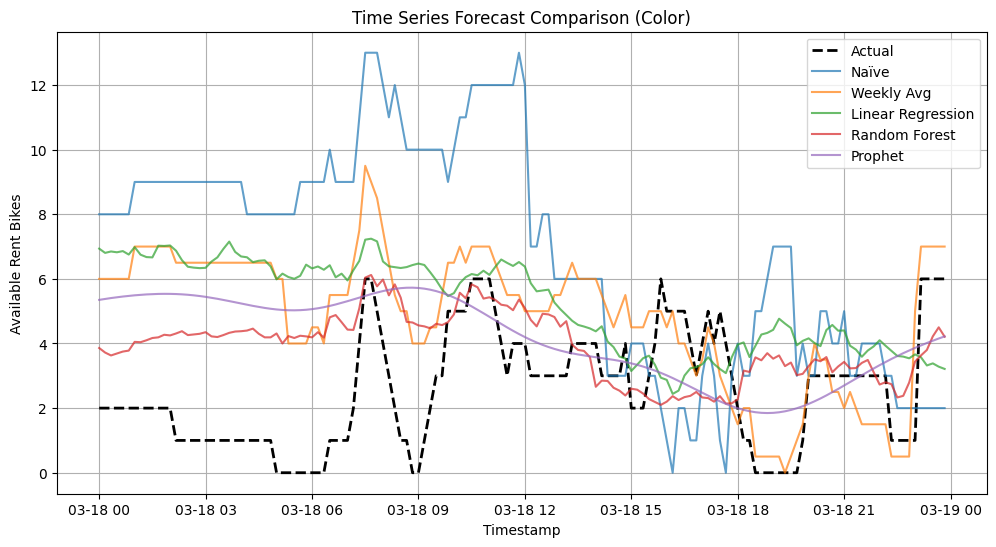

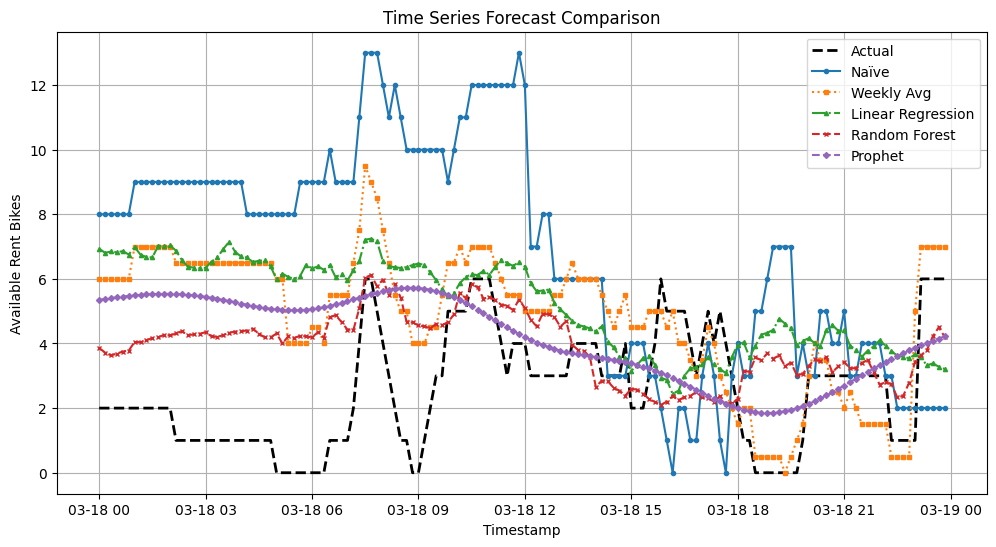

In [5]:
import matplotlib.pyplot as plt

# Plot the forecast comparison
plt.figure(figsize=(12, 6))
last_day = y_test.index[-144:]  # Extract the last day's timestamps
# Standard color plot
plt.plot(last_day, y_test.loc[last_day], label="Actual", color='black', linestyle='dashed', linewidth=2)
plt.plot(last_day, results["Naïve"].loc[last_day], label="Naïve", alpha=0.7)
plt.plot(last_day, results["Weekly Avg"].loc[last_day], label="Weekly Avg", alpha=0.7)
plt.plot(last_day, results["Linear Regression"].loc[last_day], label="Linear Regression", alpha=0.7)
plt.plot(last_day, results["Random Forest"].loc[last_day], label="Random Forest", alpha=0.7)
plt.plot(last_day, results["Prophet"].loc[last_day], label="Prophet", alpha=0.7)
#plt.plot(last_day, results["ARIMA"].loc[last_day], label="ARIMA", alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("Available Rent Bikes")
plt.title("Time Series Forecast Comparison (Color)")
plt.legend()
plt.grid()
# plt.show()
plt.savefig(f"./predictionResults/{station}/forecast_results_{station}_simple.png")


# Black-and-white plot
plt.figure(figsize=(12, 6))
plt.plot(last_day, y_test.loc[last_day], label="Actual", color='black', linestyle='dashed', linewidth=2)
plt.plot(last_day, results["Naïve"].loc[last_day], label="Naïve", linestyle='solid', marker='o', markersize=3)
plt.plot(last_day, results["Weekly Avg"].loc[last_day], label="Weekly Avg", linestyle='dotted', marker='s', markersize=3)
plt.plot(last_day, results["Linear Regression"].loc[last_day], label="Linear Regression", linestyle='dashdot', marker='^', markersize=3)
plt.plot(last_day, results["Random Forest"].loc[last_day], label="Random Forest", linestyle='dashed', marker='x', markersize=3)
plt.plot(last_day, results["Prophet"].loc[last_day], label="Prophet", linestyle='dashed', marker='D', markersize=3)
plt.xlabel("Timestamp")
plt.ylabel("Available Rent Bikes")
plt.title("Time Series Forecast Comparison")
plt.legend()
plt.grid()
# plt.show()
plt.savefig(f"./predictionResults/{station}/forecast_results_{station}_bw.png")

print(evaluation_results)  # Preview results
# results.to_csv("forecast_results.csv")  # Uncomment to save



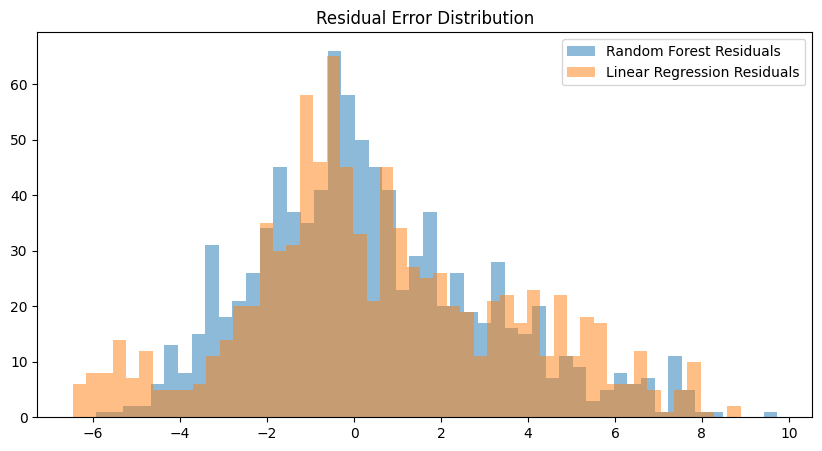

In [6]:
# just check if errors are normally distributed
plt.figure(figsize=(10, 5))
plt.hist(y_test - y_pred_rf, bins=50, alpha=0.5, label="Random Forest Residuals")
plt.hist(y_test - y_pred_lr, bins=50, alpha=0.5, label="Linear Regression Residuals")
plt.legend()
plt.title("Residual Error Distribution")
plt.show()